# Unsupervised Visualization Example

**Note:** Prior to running this example notebook, run the command under the 'Unsupervised Visualization' section of the `README`. Save the folders generated from PCA and MHSA visualization in the `example_imgs` folder and adjust paths in this notebook accordingly. 

In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import torch
from torch.nn.functional import interpolate

## Create PCA volumes

This function uses the first PCA component to mask the background, and uses the next three components mapped to RGB colorspace to create colormaps of PCA component variation over an image. 

In [2]:
def vis_pca(pth, resize=1.0):
    # load original image, and first 4 PCA components
    img = torch.tensor(nib.load(f'{pth}/orig.nii.gz').get_fdata())
    pca0 = torch.tensor(nib.load(f'{pth}/nifti_0.nii.gz').get_fdata())
    pca1 = torch.tensor(nib.load(f'{pth}/nifti_1.nii.gz').get_fdata())
    pca2 = torch.tensor(nib.load(f'{pth}/nifti_2.nii.gz').get_fdata())
    pca3 = torch.tensor(nib.load(f'{pth}/nifti_3.nii.gz').get_fdata())
    h, w, d = img.shape
    
    # background can usually be masked out with a simple threshold (may arbitrarily need to be > threshold or < threshold)
    # adjust this for your image!
    bg_mask = (pca0 > 0.5).float()
    
    # create PCA volume and normalize each component
    pca_vol = torch.stack([pca1, pca2, pca3], dim=3)
    pca_min = pca_vol.view(-1, 3).min(dim=0).values.reshape(1, 1, 1, -1)
    pca_max = pca_vol.view(-1, 3).max(dim=0).values.reshape(1, 1, 1, -1)
    pca_vol = (pca_vol - pca_min) / (pca_max - pca_min)
    
    # can make volumes smaller for faster visualization
    bg_mask = interpolate(
        bg_mask.unsqueeze(0).unsqueeze(0), size=(int(h*resize), int(w*resize), int(d*resize)), mode='nearest'
    ).bool()[0, 0]
    pca_vol = interpolate(
        pca_vol.unsqueeze(0).permute(0, 4, 1, 2, 3), size=(int(h*resize), int(w*resize), int(d*resize)), mode='nearest'
    )[0].permute(1, 2, 3, 0)
    img = interpolate(
        img.unsqueeze(0).unsqueeze(0), size=(int(h*resize), int(w*resize), int(d*resize)), mode='trilinear'
    )[0, 0]
    
    # set the PCA volume background to white
    pca_vol[bg_mask, :] = 1.0
    
    # this can improve PCA visualization contrast, adjust for your image!
    pca_vol[pca_vol < 0.4] = 0
    return img.numpy(), pca_vol.numpy()


## Visualize example image

This code visualizes an example image using generated PCA and MHSA volumes. 

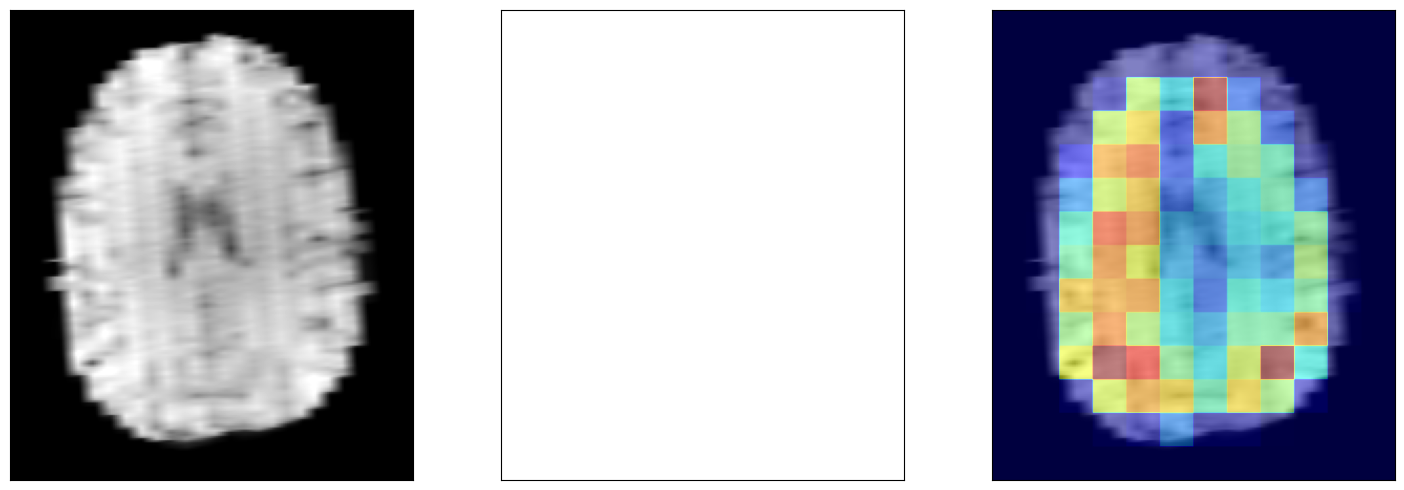

In [12]:
z = 20  # z-axis slice to visualize
mhsa_ind = 4  # MHSA head index for vis

base_mhsa = '/home/jovyan/shared/pedro-maciasgordaliza/fomo25/Dino3D_model/output_vis_dir_mhsa'
base_pca = '/home/jovyan/shared/pedro-maciasgordaliza/fomo25/Dino3D_model/output_vis_dir_pca/'

# create volumes, adjust these paths to your created folders!
img, pca_vol = vis_pca(base_pca, resize=1.0)
mhsa_vol = nib.load(f'{base_mhsa}/nifti_{mhsa_ind}.nii.gz').get_fdata()
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for ax in fig.axes:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
# display volumes
axs[0].imshow(np.rot90(img[:, :, z]), cmap='gray')
axs[1].imshow(np.rot90(pca_vol[:, :, z, :]))
axs[2].imshow(np.rot90(img[:, :, z]), cmap='gray')
axs[2].imshow(np.rot90(mhsa_vol[:, :, z]), cmap='jet', alpha=0.5)

plt.tight_layout()
plt.show()

In [13]:

def visualize_all_mhsa_heads(base_mhsa, base_pca, z_slice=20, num_heads=16):
    """
    Visualize all MHSA attention heads for a given slice
    
    Args:
        base_mhsa: Path to MHSA output directory
        base_pca: Path to PCA output directory  
        z_slice: Z-axis slice to visualize
        num_heads: Number of attention heads (usually 16)
    """
    
    # Load original image and PCA
    img, pca_vol = vis_pca(base_pca, resize=1.0)
    
    # Check image dimensions
    print(f"Image shape: {img.shape}")
    print(f"Using z-slice: {z_slice}")
    
    # Create subplot grid (4x4 for 16 heads)
    rows, cols = 4, 4
    fig, axs = plt.subplots(rows, cols, figsize=(20, 20))
    fig.suptitle(f'All MHSA Attention Heads - Z-slice {z_slice}', fontsize=16, y=0.95)
    
    # Load and display each head
    for head_idx in range(num_heads):
        try:
            # Load attention map for this head
            mhsa_vol = nib.load(f'{base_mhsa}/nifti_{head_idx}.nii.gz').get_fdata()
            
            # Calculate subplot position
            row = head_idx // cols
            col = head_idx % cols
            
            # Display original image
            axs[row, col].imshow(np.rot90(img[:, :, z_slice]), cmap='gray')
            
            # Overlay attention map
            axs[row, col].imshow(np.rot90(mhsa_vol[:, :, z_slice]), 
                                cmap='jet', alpha=0.6)
            
            # Set title and remove axes
            axs[row, col].set_title(f'Head {head_idx}', fontsize=12)
            axs[row, col].axis('off')
            
        except Exception as e:
            print(f"Error loading head {head_idx}: {e}")
            axs[row, col].text(0.5, 0.5, f'Head {head_idx}\nError loading', 
                              ha='center', va='center', transform=axs[row, col].transAxes)
            axs[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

def compare_slices_single_head(base_mhsa, base_pca, head_idx=4, z_slices=[10, 20, 30, 40]):
    """
    Compare different slices for a single MHSA head
    
    Args:
        base_mhsa: Path to MHSA output directory
        base_pca: Path to PCA output directory
        head_idx: Which attention head to visualize
        z_slices: List of z-slices to compare
    """
    
    # Load original image and attention map
    img, pca_vol = vis_pca(base_pca, resize=1.0)
    mhsa_vol = nib.load(f'{base_mhsa}/nifti_{head_idx}.nii.gz').get_fdata()
    
    # Create subplot grid
    num_slices = len(z_slices)
    fig, axs = plt.subplots(2, num_slices, figsize=(5*num_slices, 10))
    fig.suptitle(f'MHSA Head {head_idx} - Different Slices', fontsize=16)
    
    for i, z in enumerate(z_slices):
        # Original image
        axs[0, i].imshow(np.rot90(img[:, :, z]), cmap='gray')
        axs[0, i].set_title(f'Original - Z={z}')
        axs[0, i].axis('off')
        
        # Attention overlay
        axs[1, i].imshow(np.rot90(img[:, :, z]), cmap='gray')
        axs[1, i].imshow(np.rot90(mhsa_vol[:, :, z]), cmap='jet', alpha=0.6)
        axs[1, i].set_title(f'Attention - Z={z}')
        axs[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

def interactive_head_browser(base_mhsa, base_pca, z_slice=20):
    """
    Create an interactive browser to explore different heads
    """
    img, pca_vol = vis_pca(base_pca, resize=1.0)
    
    def plot_heads(selected_heads, z=z_slice):
        num_heads = len(selected_heads)
        cols = min(4, num_heads)
        rows = (num_heads + cols - 1) // cols
        
        fig, axs = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
        if num_heads == 1:
            axs = [axs]
        elif rows == 1:
            axs = [axs]
        else:
            axs = axs.flatten()
        
        fig.suptitle(f'Selected MHSA Heads - Z-slice {z}', fontsize=14)
        
        for i, head_idx in enumerate(selected_heads):
            mhsa_vol = nib.load(f'{base_mhsa}/nifti_{head_idx}.nii.gz').get_fdata()
            
            axs[i].imshow(np.rot90(img[:, :, z]), cmap='gray')
            axs[i].imshow(np.rot90(mhsa_vol[:, :, z]), cmap='jet', alpha=0.6)
            axs[i].set_title(f'Head {head_idx}')
            axs[i].axis('off')
        
        # Hide empty subplots
        for i in range(num_heads, len(axs)):
            axs[i].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return plot_heads

In [14]:
# Your paths
base_mhsa = '/home/jovyan/shared/pedro-maciasgordaliza/fomo25/Dino3D_model/output_sub-15_t2_vis_dir_mhsa'
base_pca = '/home/jovyan/shared/pedro-maciasgordaliza/fomo25/Dino3D_model/output_sub-15_t2_vis_dir_pca/'

## 1. VISUALIZE ALL 16 HEADS FOR ONE SLICE

Displaying all MHSA heads for z-slice 20...
Image shape: (512, 512, 32)
Using z-slice: 20


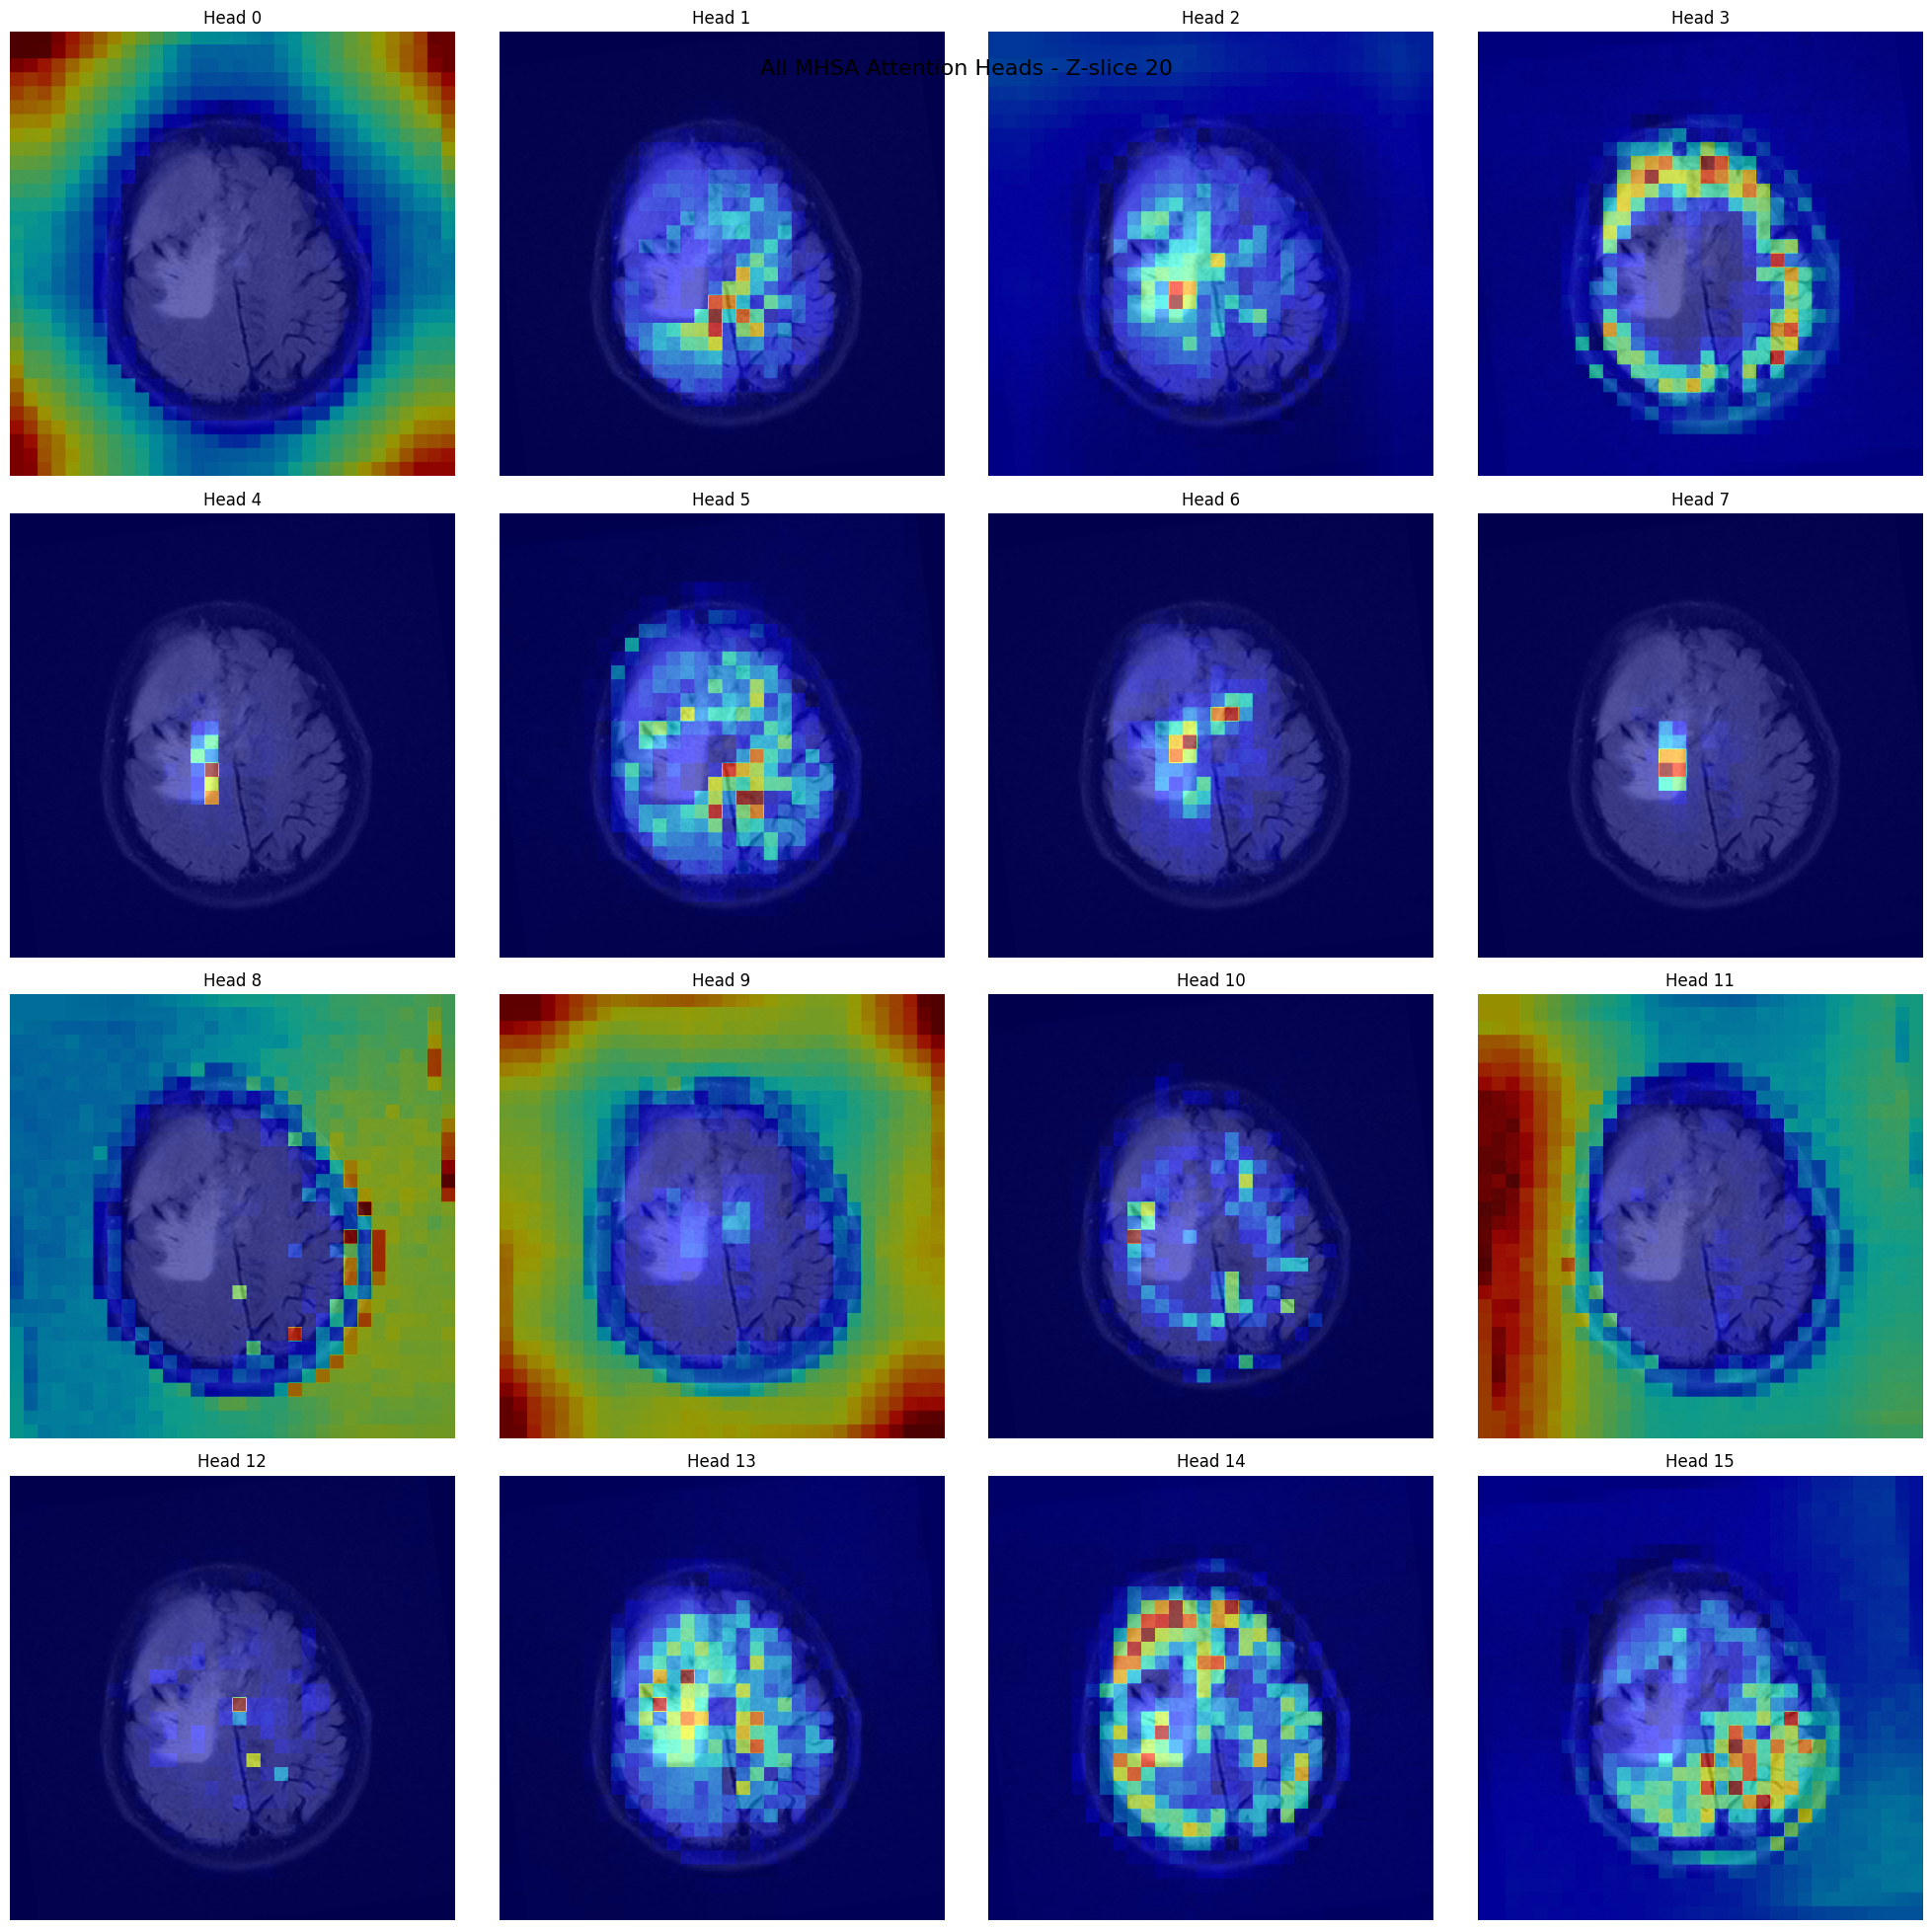

In [15]:
print("Displaying all MHSA heads for z-slice 20...")
visualize_all_mhsa_heads(base_mhsa, base_pca, z_slice=20)

## 2. COMPARE DIFFERENT SLICES FOR ONE HEAD

Comparing different slices for head 4...


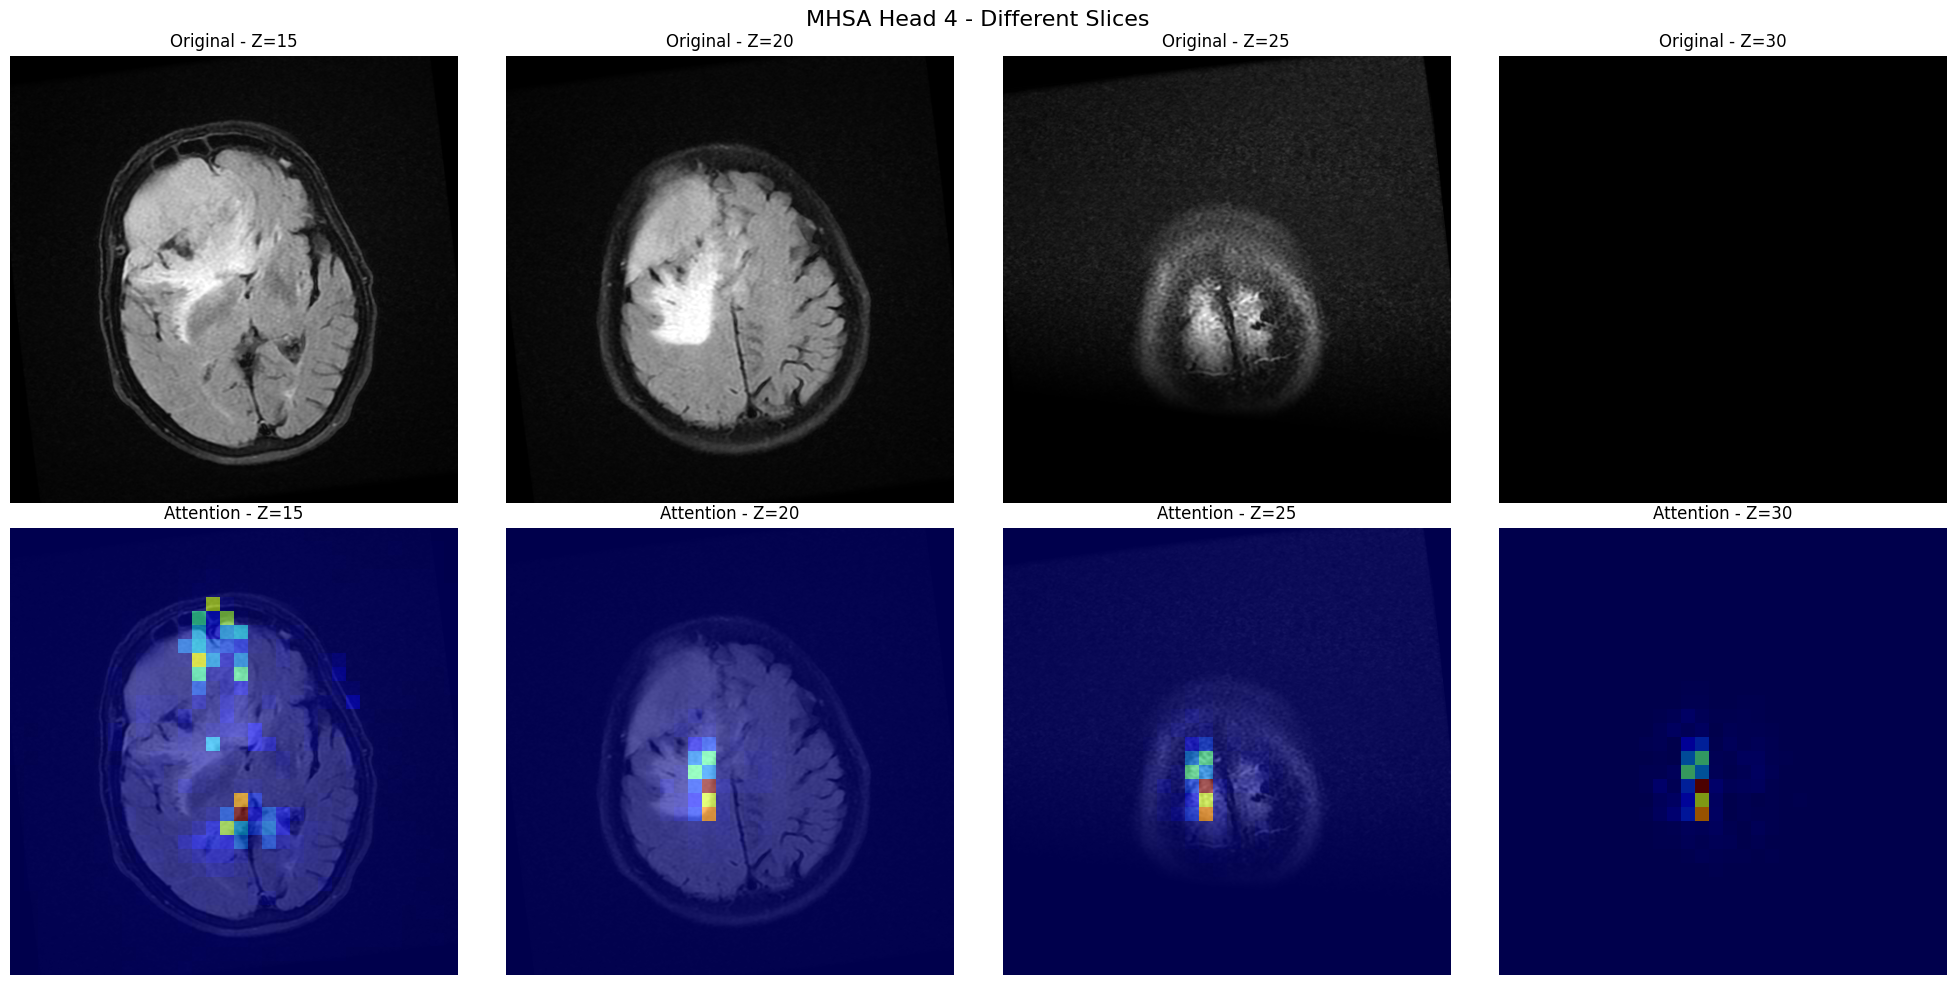

In [17]:
print("Comparing different slices for head 4...")
compare_slices_single_head(base_mhsa, base_pca, head_idx=4, z_slices=[15, 20, 25, 30])

## 3. CUSTOM SELECTION OF HEADS


Displaying selected interesting heads...


AttributeError: 'numpy.ndarray' object has no attribute 'imshow'

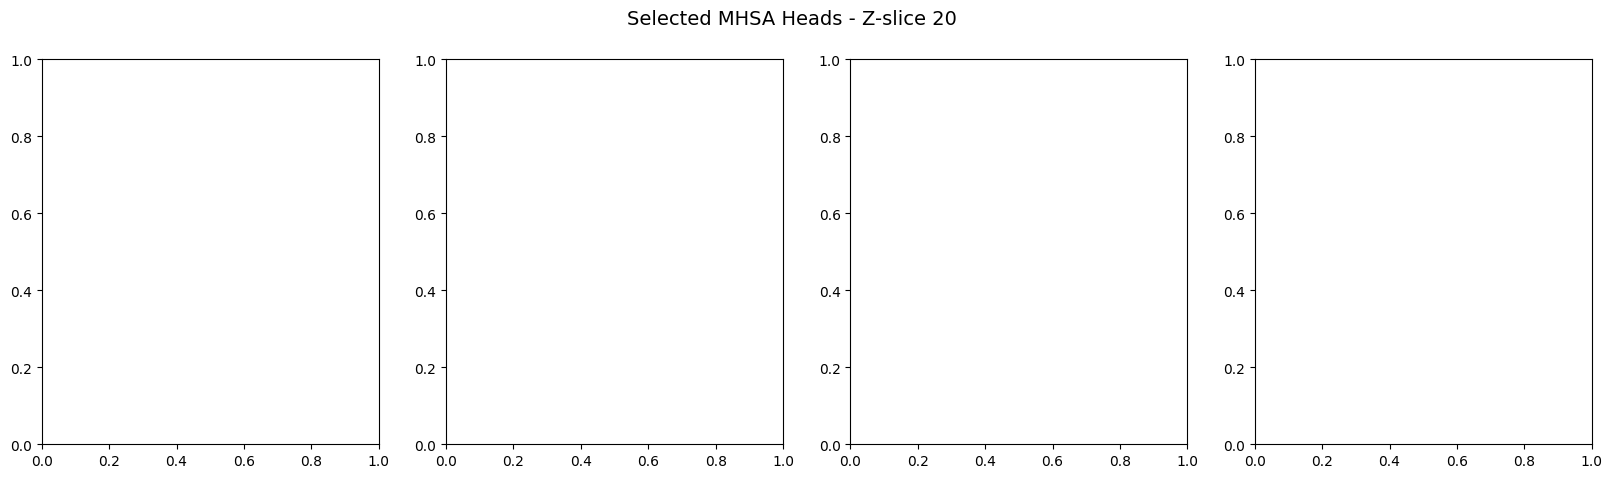

In [19]:
print("Displaying selected interesting heads...")
plot_heads = interactive_head_browser(base_mhsa, base_pca, z_slice=20)

# Show specific heads that might be interesting
interesting_heads = [0, 4, 8, 12]  # You can adjust these
plot_heads(interesting_heads, z=20)

 ## 4. QUICK FUNCTION FOR ANY SLICE/HEADS COMBINATION

In [20]:
def quick_viz(z_slice, head_list):
    """Quick visualization function"""
    img, pca_vol = vis_pca(base_pca, resize=1.0)
    
    num_heads = len(head_list)
    fig, axs = plt.subplots(1, num_heads, figsize=(5*num_heads, 5))
    if num_heads == 1:
        axs = [axs]
    
    for i, head_idx in enumerate(head_list):
        mhsa_vol = nib.load(f'{base_mhsa}/nifti_{head_idx}.nii.gz').get_fdata()
        
        axs[i].imshow(np.rot90(img[:, :, z_slice]), cmap='gray')
        axs[i].imshow(np.rot90(mhsa_vol[:, :, z_slice]), cmap='jet', alpha=0.6)
        axs[i].set_title(f'Head {head_idx}')
        axs[i].axis('off')
    
    plt.suptitle(f'Z-slice {z_slice}')
    plt.tight_layout()
    plt.show()

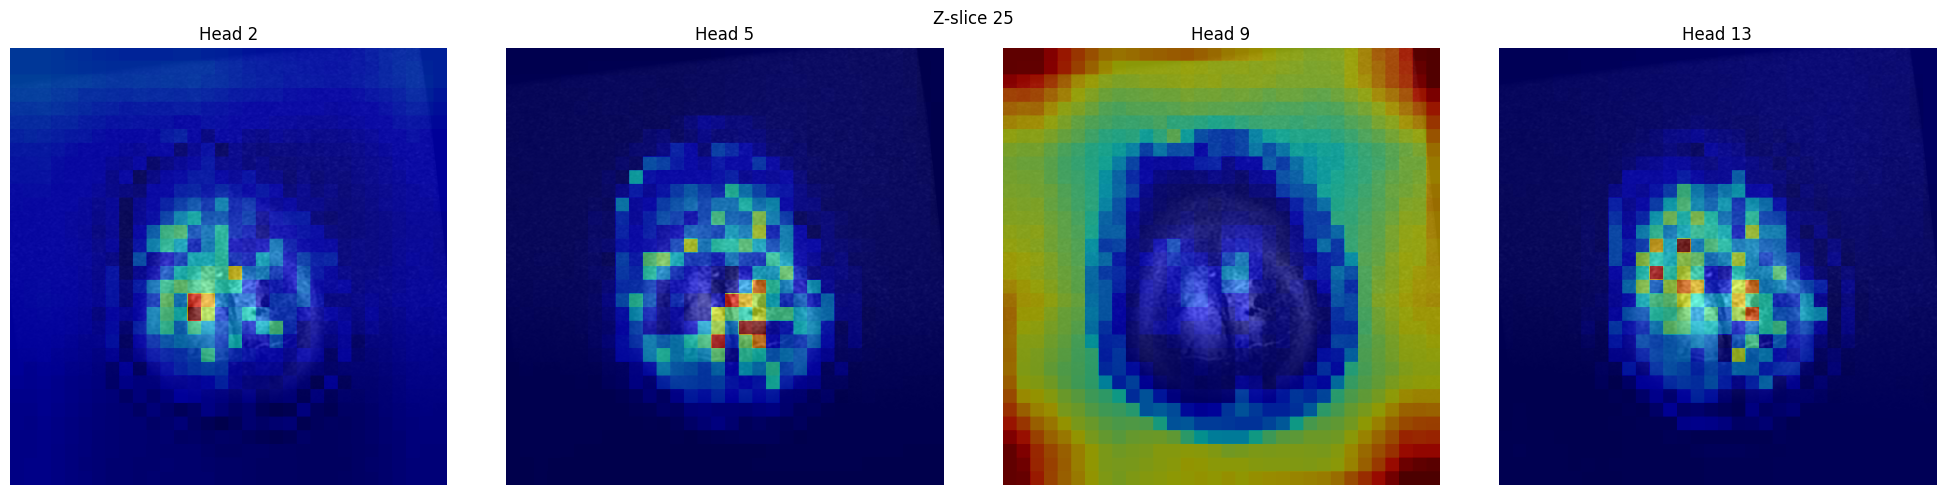

In [21]:
quick_viz(z_slice=25, head_list=[2, 5, 9, 13])

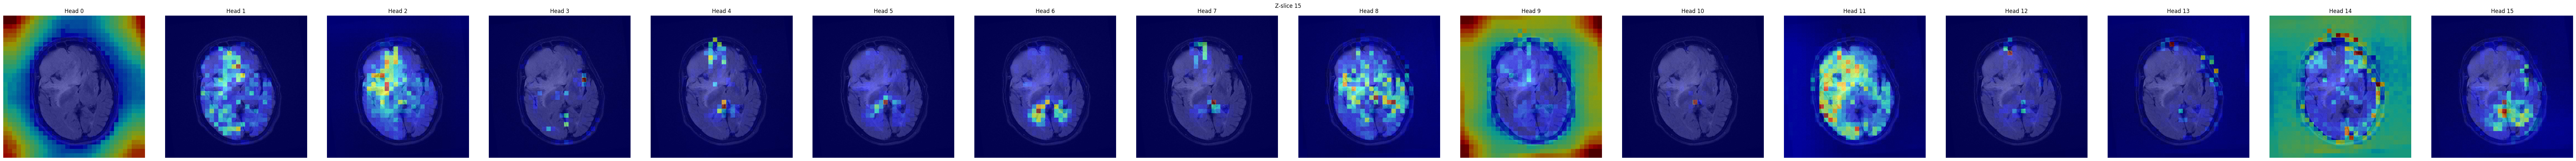

In [22]:
quick_viz(z_slice=15, head_list=list(range(16)))

In [23]:
base_mhsa = '/home/jovyan/shared/pedro-maciasgordaliza/fomo25/Dino3D_model/output_sub-18_t2_vis_dir_mhsa'
base_pca = '/home/jovyan/shared/pedro-maciasgordaliza/fomo25/Dino3D_model/output_sub-18_t2_vis_dir_pca/'

Image shape: (208, 256, 32)
Using z-slice: 12


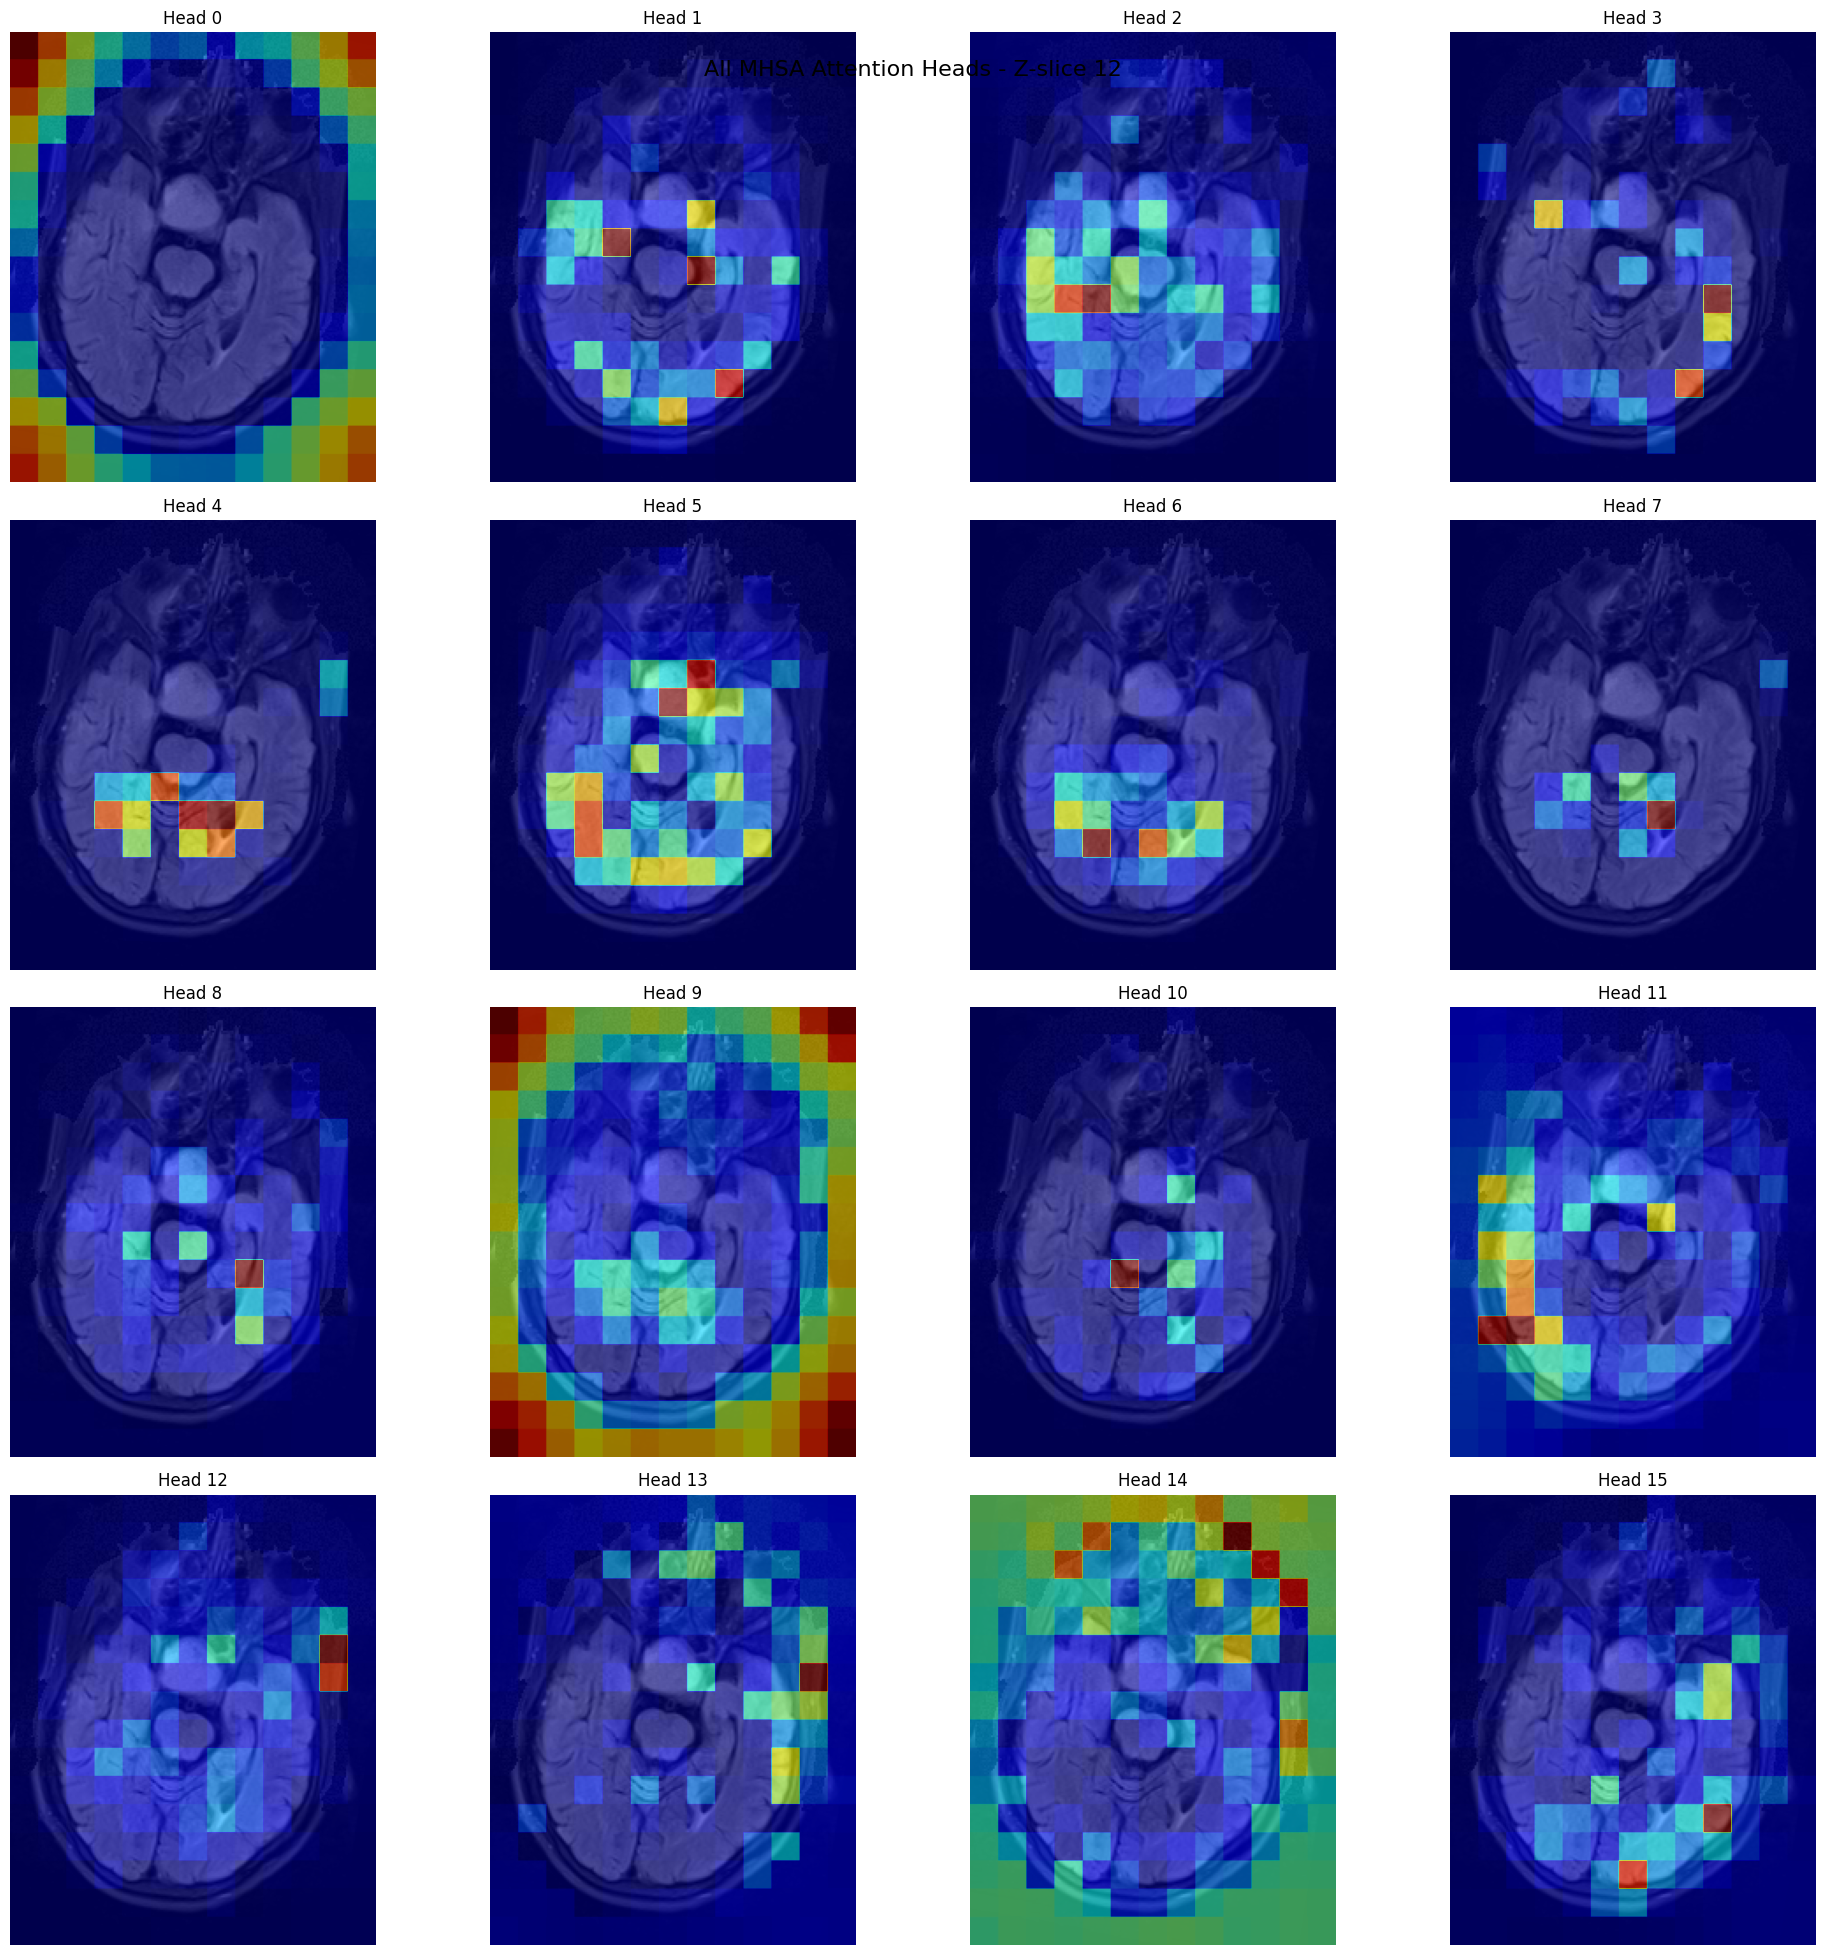

In [26]:
visualize_all_mhsa_heads(base_mhsa, base_pca, z_slice=12)